In [1]:
# Revenue whi loss ho rha hai jaha par ticket cancle hui hai 
# 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dim_data = pd.read_csv('dim_date.csv')
dim_hotels = pd.read_csv('dim_hotels.csv')
dim_rooms = pd.read_csv('dim_rooms.csv')
fact_aggregated_booking = pd.read_csv('fact_aggregated_bookings.csv')
fact_bookings = pd.read_csv('fact_bookings.csv')

In [5]:
List = [dim_data , dim_hotels , dim_rooms , fact_aggregated_booking , fact_bookings]
for i in List:
    print(i.shape)
    print(i.head())

(92, 4)
        date  mmm yy week no  day_type
0  01-May-22  May 22    W 19   weekend
1  02-May-22  May 22    W 19  weekeday
2  03-May-22  May 22    W 19  weekeday
3  04-May-22  May 22    W 19  weekeday
4  05-May-22  May 22    W 19  weekeday
(25, 4)
   property_id  property_name  category    city
0        16558   Atliq Grands    Luxury   Delhi
1        16559  Atliq Exotica    Luxury  Mumbai
2        16560     Atliq City  Business   Delhi
3        16561      Atliq Blu    Luxury   Delhi
4        16562      Atliq Bay    Luxury   Delhi
(4, 2)
  room_id    room_class
0     RT1      Standard
1     RT2         Elite
2     RT3       Premium
3     RT4  Presidential
(9200, 5)
   property_id check_in_date room_category  successful_bookings  capacity
0        16559     01-May-22           RT1                   25        30
1        19562     01-May-22           RT1                   28        30
2        19563     01-May-22           RT1                   23        30
3        17558     01-May-22 

In [4]:
bookdays_count = dim_data["day_type"].value_counts()
booking_status_count = fact_bookings["booking_status"].value_counts()
print(booking_status_count)
print(bookdays_count)

booking_status
Checked Out    94411
Cancelled      33420
No Show         6759
Name: count, dtype: int64
day_type
weekeday    65
weekend     27
Name: count, dtype: int64


In [5]:
fact_bookings["revenue_leakage"] = fact_bookings["revenue_realized"] - fact_bookings["revenue_generated"]

In [6]:
fact_bookings["ratings_given"].value_counts()

ratings_given
5.0    19480
3.0    17561
4.0     9653
2.0     6452
1.0     3537
Name: count, dtype: int64

In [7]:
# Average realized revenue per guest
fact_bookings["revenue_per_guest"] = fact_bookings["revenue_realized"] / fact_bookings["no_guests"]

avg_rev = fact_bookings.groupby("no_guests")["revenue_per_guest"].mean()
print(avg_rev)

no_guests
1    12243.321373
2     6065.200588
3     4443.718490
4     3489.264137
5     4406.642991
6     3995.073587
Name: revenue_per_guest, dtype: float64


In [8]:
fact_bookings["room_category"].value_counts()

room_category
RT2    49505
RT1    38446
RT3    30566
RT4    16073
Name: count, dtype: int64

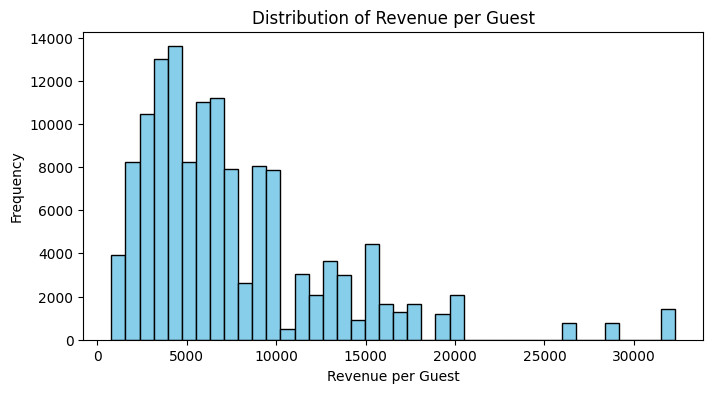

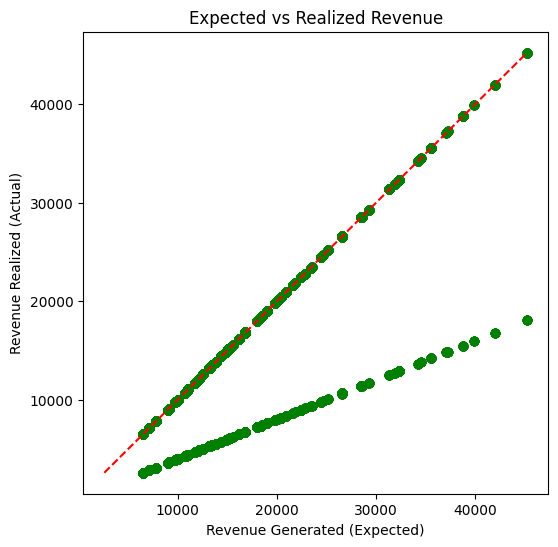

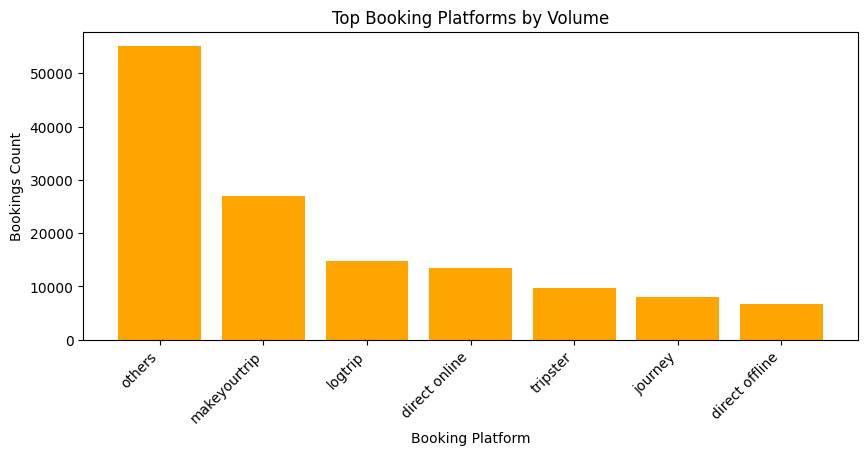

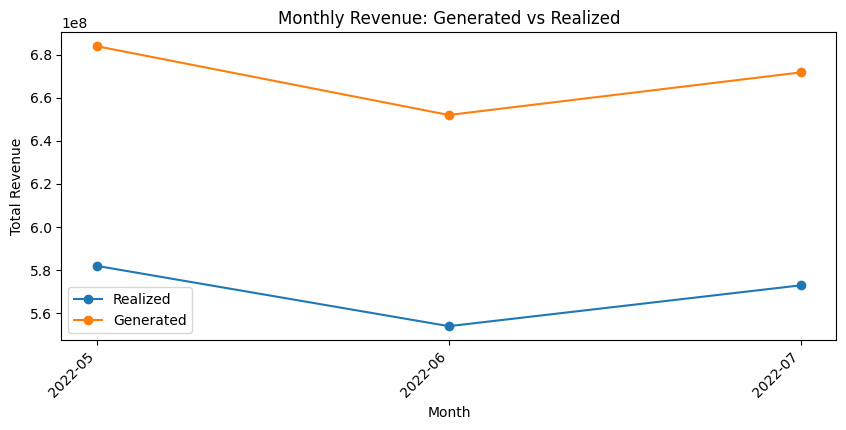

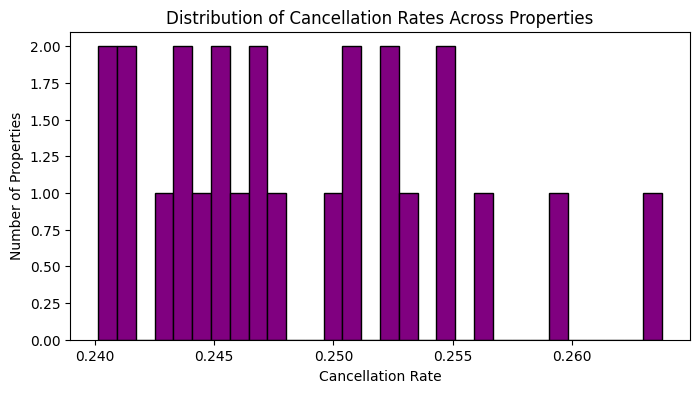

In [9]:
import matplotlib.pyplot as plt

# 1️⃣ Distribution of revenue per guest
plt.figure(figsize=(8,4))
plt.hist(fact_bookings["revenue_per_guest"].dropna(), bins=40, color="skyblue", edgecolor="black")
plt.xlabel("Revenue per Guest")
plt.ylabel("Frequency")
plt.title("Distribution of Revenue per Guest")
plt.show()

# 2️⃣ Scatter plot: Expected vs Realized Revenue
plt.figure(figsize=(6,6))
plt.scatter(fact_bookings["revenue_generated"], fact_bookings["revenue_realized"], alpha=0.4, color="green")
plt.xlabel("Revenue Generated (Expected)")
plt.ylabel("Revenue Realized (Actual)")
plt.title("Expected vs Realized Revenue")
# Ideal line (perfect case: generated = realized)
lims = [
    min(fact_bookings["revenue_generated"].min(), fact_bookings["revenue_realized"].min()),
    max(fact_bookings["revenue_generated"].max(), fact_bookings["revenue_realized"].max()),
]
plt.plot(lims, lims, linestyle="--", color="red")
plt.show()

# 3️⃣ Bar chart: Top 10 booking platforms by bookings count
platform_stats = fact_bookings.groupby("booking_platform").agg(
    bookings_count=("booking_id", "nunique"),
    cancel_rate=("booking_status", lambda x: (x.str.lower() == "cancelled").mean())
).sort_values("bookings_count", ascending=False).reset_index()

top_platforms = platform_stats.head(10)

plt.figure(figsize=(10,4))
plt.bar(top_platforms["booking_platform"], top_platforms["bookings_count"], color="orange")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Booking Platform")
plt.ylabel("Bookings Count")
plt.title("Top Booking Platforms by Volume")
plt.show()

# Convert check_in_date to datetime
fact_bookings["check_in_date"] = pd.to_datetime(fact_bookings["check_in_date"], errors="coerce")

# Extract month
fact_bookings["month"] = fact_bookings["check_in_date"].dt.to_period("M").astype(str)

# Group by month
monthly = fact_bookings.groupby("month").agg(
    total_realized=("revenue_realized","sum"),
    total_generated=("revenue_generated","sum")
).reset_index()

plt.figure(figsize=(10,4))
plt.plot(monthly["month"], monthly["total_realized"], marker="o", label="Realized")
plt.plot(monthly["month"], monthly["total_generated"], marker="o", label="Generated")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.title("Monthly Revenue: Generated vs Realized")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.show()

# 5️⃣ Histogram: Distribution of property-level cancellation rates
cancel_rate = fact_bookings.groupby("property_id").agg(
    cancel_rate=("booking_status", lambda x: (x.str.lower() == "cancelled").mean())
).reset_index()

plt.figure(figsize=(8,4))
plt.hist(cancel_rate["cancel_rate"].dropna(), bins=30, color="purple", edgecolor="black")
plt.xlabel("Cancellation Rate")
plt.ylabel("Number of Properties")
plt.title("Distribution of Cancellation Rates Across Properties")
plt.show()


In [10]:
import pandas as pd
from scipy import stats

# Example: Revenue per guest difference between OTA and Direct platforms
ota = fact_bookings.loc[fact_bookings["booking_platform"]=="OTA", "revenue_per_guest"].dropna()
direct = fact_bookings.loc[fact_bookings["booking_platform"]=="Direct", "revenue_per_guest"].dropna()

t_stat, p_value = stats.ttest_ind(ota, direct, equal_var=False)  # Welch’s t-test
print("T-statistic:", t_stat, "P-value:", p_value)

if p_value < 0.05:
    print("Reject H0 → Significant difference in revenue per guest between OTA and Direct")
else:
    print("Fail to reject H0 → No significant difference")


T-statistic: nan P-value: nan
Fail to reject H0 → No significant difference


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19336\2622465101.py:8: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_ind(ota, direct, equal_var=False)  # Welch’s t-test
